In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
from datetime import datetime
from scipy.linalg import eig

In [3]:
bond_data_list = [['CA135087Q988', 0.0400, '10/13/2023', '03/01/2029', 'CAN 4.00 Mar 1', 103.406, 103.38, 103.279, 103.132, 103.542, 103.552, 102.974, 102.483, 102.279, 102.242, 0.5],
                  ['CA135087M508', 0.0075, '07/12/2021', '10/01/2024', 'CAN 0.75 Oct 1', 97.22, 97.22, 97.234, 97.255, 97.308, 97.348, 97.258, 97.225, 97.249, 97.256, 1.0],
                  ['CA135087N340', 0.0150, '01/24/2022', '04/01/2029', 'CAN 1.50 May 1', 96.533, 96.545, 96.591, 96.64, 96.72, 96.68, 96.62, 96.5, 96.49, 96.48, 1.5],
                  ['CA135087E679', 0.0150, '07/21/2015', '06/01/2029', 'CAN 1.50 Jun 1', 94.97,	95.01, 95.06,	95.06, 95.17, 95.14, 95, 94.74, 94.69, 94.66, 2.0],
                  ['CA135087J397', 0.0225, '07/27/2018', '06/01/2029', 'CAN 2.25 Jun 1', 95.29,	95.25, 95.35,	95.14, 95.42, 95.44, 95.36, 94.49, 94.28,	94.22, 2.5],
                  ['CA135087K528', 0.0125, '10/11/2019', '03/01/2029', 'CAN 1.25 Mar 1', 96.46,	96.482, 96.552,	96.576,	96.661,	96.715,	96.54, 96.448, 96.495, 96.46, 3.0],
                  ['CA135087N910', 0.0275, '05/24/2022', '08/01/2029', 'CAN 2.75 Aug 1', 98.818, 98.822, 98.835,	98.841,	98.878,	98.909,	98.839,	98.832,	98.856, 98.86, 3.5],
                  ['CA135087L930', 0.0100, '04/16/2021', '09/01/2029', 'CAN 1.00 Sep 1', 93.46,	93.44, 93.55,	93.53, 93.6, 93.57, 93.4,	93.12, 93.08, 93.07, 4.0],
                  ['CA135087P402', 0.0300, '08/15/2022', '11/01/2029', 'CAN 3.00 Nov 1', 98.624, 98.624, 98.658, 98.648, 98.702,	98.748,	98.629, 98.586,	98.587,	98.59, 4.5],
                  ['CA135087P816', 0.0300, '01/20/2023', '04/01/2029', 'CAN 3.00 May 1', 98.27,	98.28, 98.37,	98.35, 98.43, 98.44, 98.3, 98.05,	98, 97.99, 5.0]]
columns=['ISIN', 'Coupon', 'Issue_Date', "Maturity_Date", "Name", "2024/1/8", "2024/1/9", "2024/1/10", "2024/1/11", "2024/1/12", "2024/1/15", "2024/1/16", "2024/1/17", "2024/1/18", "2024/1/19", "time_to_maturity"]
bonds_df = pd.DataFrame(bond_data_list, columns=columns)

In [4]:
def calc_zero_coupon_rate(notional, market_price, to_maturity):
    discount_factor = market_price / notional
    rate = -1  * np.log(discount_factor) / to_maturity
    return rate

def annual_coupon(coupon_rate, par):
    return coupon_rate * par / 2

def ytm_equation(ytm, prices, annual_coup, maturity_years, par):
    cash_flows = []
    for t in np.arange(0.5, maturity_years, 0.5):
        cash_flow_at_t =  np.exp(-ytm * t) * annual_coup
        cash_flows.append(cash_flow_at_t)

    new_cash_flow = (par + annual_coup) * np.exp(-ytm * maturity_years)
    cash_flows.append(new_cash_flow)
    equation = sum(cash_flows) - prices
    return equation

def compute_bond_ytm(price, coupon_rate, years_to_mat, face_value):
    annual_coupon_payment = annual_coupon(coupon_rate, face_value)
    return newton(ytm_equation, 0.02, args=(price, annual_coupon_payment, years_to_mat, face_value))

def evaluate_discounted_cash_flows(coupon_payment, spot_rates, maturity_years):
    discounted_cash_flows = []
    for index, rate in enumerate(spot_rates):
        time = (index + 1) * 0.5
        if time < maturity_years:
            discounted_cash_flow = coupon_payment * np.exp(-rate * time)
            discounted_cash_flows.append(discounted_cash_flow)
    total_discounted_cash_flows = sum(discounted_cash_flows)
    return total_discounted_cash_flows

def calculate_bond_spot_rate(existing_spot_rates, bond_price, coupon_rate, maturity_years, face_value):
    semi_annual_coupon_payment = annual_coupon(coupon_rate, face_value)
    if maturity_years != 0.5:
        discounted_coupons = evaluate_discounted_cash_flows(semi_annual_coupon_payment, existing_spot_rates, maturity_years)
        remaining_value = bond_price - discounted_coupons
        new_spot_rate = -np.log(remaining_value / (face_value + semi_annual_coupon_payment)) / maturity_years
        existing_spot_rates.append(new_spot_rate)
    else:
        immediate_rate = calc_zero_coupon_rate(face_value + semi_annual_coupon_payment, bond_price, maturity_years)
        existing_spot_rates.append(immediate_rate)
    return existing_spot_rates

In [5]:
def convert_to_datetime(date_string):
    date_object = datetime.strptime(date_string, "%m/%d/%Y")
    formatted_date = date_object.strftime("%Y-%m-%d")
    return formatted_date

In [6]:
bonds_df

,ISIN,Coupon,Issue_Date,Maturity_Date,Name,2024/1/8,2024/1/9,2024/1/10,2024/1/11,2024/1/12,2024/1/15,2024/1/16,2024/1/17,2024/1/18,2024/1/19,time_to_maturity
0,CA135087Q988,0.0400,10/13/2023,03/01/2029,CAN 4.00 Mar 1,103.406,103.380,103.279,103.132,103.542,103.552,102.974,102.483,102.279,102.242,0.5
1,CA135087M508,0.0075,07/12/2021,10/01/2024,CAN 0.75 Oct 1,97.220,97.220,97.234,97.255,97.308,97.348,97.258,97.225,97.249,97.256,1.0
2,CA135087N340,0.0150,01/24/2022,04/01/2029,CAN 1.50 May 1,96.533,96.545,96.591,96.640,96.720,96.680,96.620,96.500,96.490,96.480,1.5
3,CA135087E679,0.0150,07/21/2015,06/01/2029,CAN 1.50 Jun 1,94.970,95.010,95.060,95.060,95.170,95.140,95.000,94.740,94.690,94.660,2.0
4,CA135087J397,0.0225,07/27/2018,06/01/2029,CAN 2.25 Jun 1,95.290,95.250,95.350,95.140,95.420,95.440,95.360,94.490,94.280,94.220,2.5
5,CA135087K528,0.0125,10/11/2019,03/01/2029,CAN 1.25 Mar 1,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,3.0
6,CA135087N910,0.0275,05/24/2022,08/01/2029,CAN 2.75 Aug 1,98.818,98.822,98.835,98.841,98.878,98.909,98.839,98.832,98.856,98.860,3.5
7,CA135087L930,0.0100,04/16/2021,09/01/2029,CAN 1.00 Sep 1,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,4.0
8,CA135087P402,0.0300,08/15/2022,11/01/2029,CAN 3.00 Nov 1,98.624,98.624,98.658,98.648,98.702,98.748,98.629,98.586,98.587,98.590,4.5
9,CA135087P816,0.0300,01/20/2023,04/01/2029,CAN 3.00 May 1,98.270,98.280,98.370,98.350,98.430,98.440,98.300,98.050,98.000,97.990,5.0


In [7]:
print(len(bonds_df))

10


In [8]:
ytm_curves, bond_yields_by_date= {}, {}
dates = ["2024/1/8", "2024/1/9", "2024/1/10", "2024/1/11", "2024/1/12",
          "2024/1/15", "2024/1/16", "2024/1/17", "2024/1/18", "2024/1/19"]
portfolio_names = list(bonds_df['Name'])
num_bonds = len(bonds_df)

i = 0
while i < num_bonds:
    current_yields = []
    current_coupon = bonds_df.iloc[i, 1]
    prices = list(bonds_df.iloc[i, 5:-1])
    maturity = bonds_df.iloc[i, -1]

    for j in range(len(prices)):
        ytm = compute_bond_ytm(prices[j], current_coupon, maturity, 100)
        current_yields.append(ytm)

    ytm_curves[bonds_df.iloc[i, 4]] = current_yields
    i += 1

for current_date in dates:
    bond_yields_by_date[current_date] = []
    for bond_name in portfolio_names:
        date_index = dates.index(current_date)
        bond_yields_by_date[current_date].append(ytm_curves[bond_name][date_index])
maturity_sorted = sorted(bonds_df['time_to_maturity'].unique())

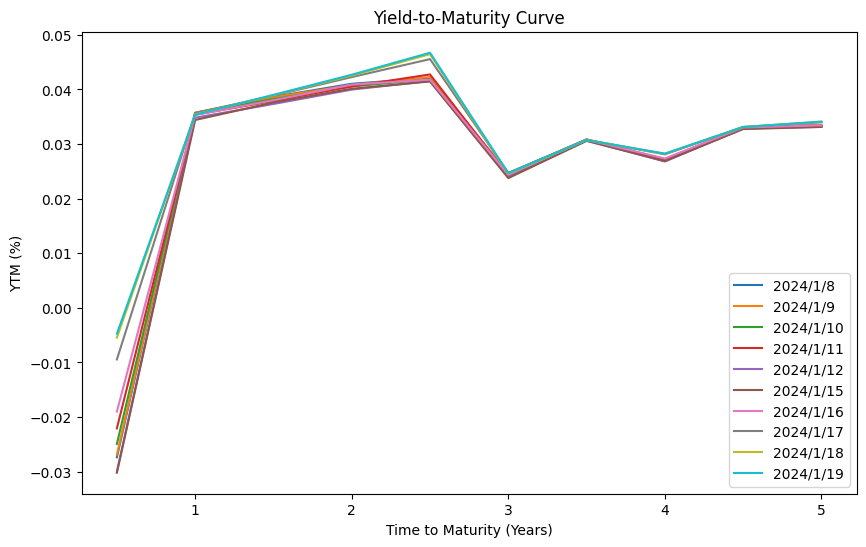

In [9]:
figure, ax = plt.subplots(figsize=(10, 6))
for current_date in dates:
    ax.plot(maturity_sorted, bond_yields_by_date[current_date], label=current_date)
plt.title("Yield-to-Maturity Curve")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("YTM (%)")
plt.legend()
plt.show()

In [27]:
spot_rates_by_date = {}
coupon_rates = list(bonds_df['Coupon'])
for current_date in dates:
    bond_prices = list(bonds_df[current_date])
    calculated_spot_rates = []
    num_dates = len(dates)
    idx = 0
    while idx < num_dates:
        current_spot_rates = calculate_bond_spot_rate(calculated_spot_rates, bond_prices[idx], coupon_rates[idx], maturity_sorted[idx], 100)
        calculated_spot_rates = current_spot_rates.copy()
        idx += 1

    spot_rates_by_date[current_date] = calculated_spot_rates
print(spot_rates_by_date)

{'2024/1/8': [-0.027380348371711168, 0.035854786560086685, 0.038832565407267365, 0.041213553000616035, 0.0423451773197241, 0.02449404115842088, 0.030786164533923712, 0.027100556922611506, 0.033175359943843644, 0.03365923437333009], '2024/1/9': [-0.026877412967244163, 0.03585379948496223, 0.03874706795678865, 0.04099749516062936, 0.042522416170021574, 0.024415318386407547, 0.03077397992059858, 0.027156182992087084, 0.033175072800591475, 0.03363566026682059], '2024/1/10': [-0.024922501581019656, 0.03570540762030715, 0.03842009405973859, 0.04072667402051685, 0.042083310587119165, 0.024168360056318724, 0.03074090771140159, 0.026853964181268314, 0.03310002519648483, 0.03343737924099695], '2024/1/11': [-0.022073815709584235, 0.03548303187942644, 0.038070267984137374, 0.040723721909701895, 0.043003590719695936, 0.02407667090795844, 0.030711123749327603, 0.026905976959973495, 0.03311540564376022, 0.03347456119411071], '2024/1/12': [-0.030009028418451433, 0.034951640690056615, 0.037533827743506

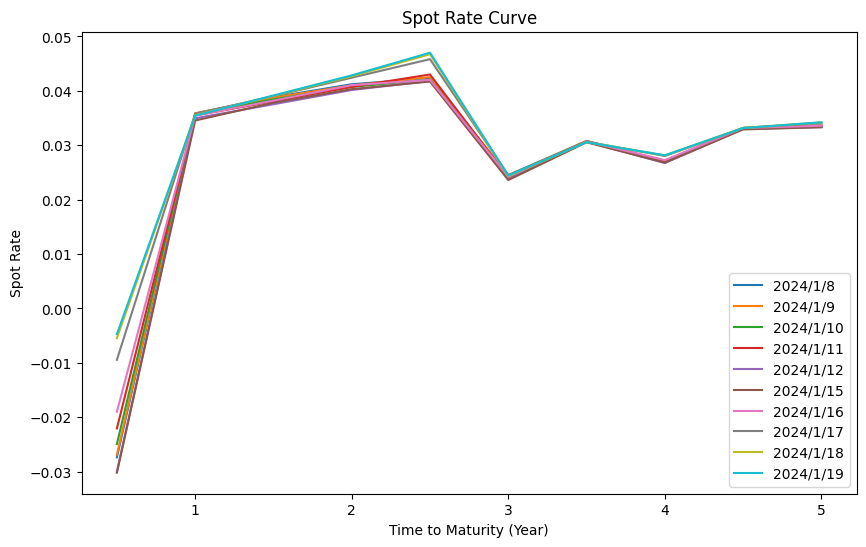

In [13]:
figure = plt.figure(figsize=(10, 6))

for date in dates:
      plt.plot(maturity_sorted, spot_rates_by_date[date], label = date)
plt.title("Spot Rate Curve")
plt.xlabel("Time to Maturity (Year)")
plt.ylabel("Spot Rate")
plt.legend()
plt.show()

In [14]:
forward_rate_curve_by_date = {}
initial_time = 1
for date in dates:
    current_spot_rates = spot_rates_by_date[date]
    forward_rates = np.zeros(4)
    idx = 0
    while idx < 4:
        time_step = [2, 3, 4, 5][idx]
        forward_rates[idx] = (current_spot_rates[time_step*2-1] * time_step - current_spot_rates[initial_time]) / (time_step - initial_time)
        idx += 1
    forward_rate_curve_by_date[date] = forward_rates

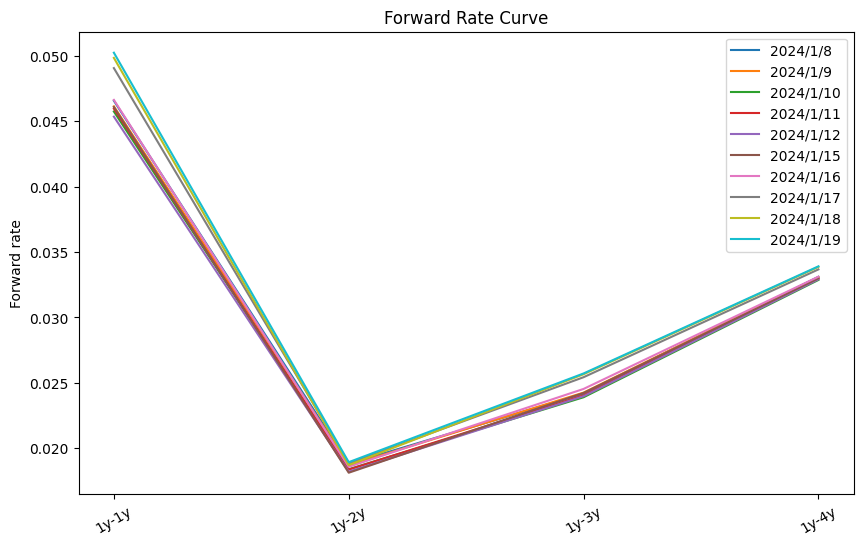

In [15]:
fig=plt.figure(figsize = (10, 6))
labels = ['1y-1y', '1y-2y', '1y-3y', '1y-4y']
for date in dates:
    plt.plot([2, 3, 4, 5], forward_rate_curve_by_date[date], label = date)
plt.title("Forward Rate Curve")
plt.ylabel("Forward rate")
plt.xticks([2, 3, 4, 5], labels, rotation=30)
plt.legend(loc='best')
plt.show()

In [38]:
ytm_matrix, forward_matrix = np.zeros([5, 9]), np.zeros([4, 9])
i, j = 0, 0
while i < 5:
    while j < 9:
        ytm_matrix[i,j] = np.log(spot_rates_by_date[dates[j+1]][2*i] / spot_rates_by_date[dates[j]][2*i])
        j += 1
    j = 0
    i += 1

In [55]:
ytm_cov_matrix = np.cov((ytm_matrix.T - np.mean(ytm_matrix.T, axis = 0)).T)
print("ytm_cov_matrix")
print(ytm_cov_matrix)
eigen_value, eigen_vector = np.linalg.eig(ytm_cov_matrix)
print("\n" * 3)
print("Eigenvalue")
print(eigen_value)
print("\n" * 3)
print("Eigenvector")
print(eigen_vector)

ytm_cov_matrix
[[ 9.95841886e-02 -2.68773157e-03 -8.23302033e-03 -2.07974757e-04
  -5.94204924e-04]
 [-2.68773157e-03  1.20554732e-04  2.64234504e-04  6.18657835e-06
   1.57897871e-05]
 [-8.23302033e-03  2.64234504e-04  1.01894643e-03 -3.35065282e-06
   3.16996495e-05]
 [-2.07974757e-04  6.18657835e-06 -3.35065282e-06  6.95529608e-06
   7.83823128e-06]
 [-5.94204924e-04  1.57897871e-05  3.16996495e-05  7.83823128e-06
   1.07279647e-05]]




Eigenvalue
[1.00343866e-01 3.43895473e-04 4.25637181e-05 1.08556792e-05
 1.92075330e-07]




Eigenvector
[[-0.99619498 -0.08486998  0.01662728  0.01059963  0.00195556]
 [ 0.02693435 -0.13698683  0.98346832 -0.11269234  0.02448788]
 [ 0.08264786 -0.98363943 -0.12803648  0.09507616 -0.01378386]
 [ 0.00206424  0.06087837  0.10234203  0.65807618 -0.74347254]
 [ 0.0059303   0.05271619  0.07514234  0.73829828  0.66817296]]


In [58]:
while i < 4:
    while j < 9:
        forward_matrix[i,j] = np.log(forward_rate_curve_by_date[dates[j+1]][i] / forward_rate_curve_by_date[dates[j]][i])
        j += 1
    j = 0
    i += 1

In [59]:
forward_cov_matrix = np.cov((forward_matrix.T - np.mean(forward_matrix.T, axis = 0)).T)
print("forward_cov_matrix")
print(forward_cov_matrix)
eigen_value, eigen_vector = np.linalg.eig(forward_cov_matrix)
print("\n" * 3)
print("Eigenvalue")
print(eigen_value)
print("\n" * 3)
print("Eigenvector")
print(eigen_vector)

forward_cov_matrix
[[3.76785691e-04 1.47504568e-04 2.42081850e-04 1.15875802e-04]
 [1.47504568e-04 1.73912499e-04 1.16082978e-04 4.91300309e-05]
 [2.42081850e-04 1.16082978e-04 1.85077821e-04 8.41333586e-05]
 [1.15875802e-04 4.91300309e-05 8.41333586e-05 4.02840407e-05]]




Eigenvalue
[6.56950829e-04 9.80978567e-05 1.98067540e-05 1.20461205e-06]




Eigenvector
[[-0.73672595 -0.37959582  0.55370734 -0.08093251]
 [-0.37220278  0.91717672  0.1383921   0.03315993]
 [-0.51194422 -0.07707033 -0.78404371 -0.34241602]
 [-0.23793503 -0.09356302 -0.2439903   0.93546866]]
